In [1]:
# Cell 1: Import necessary libraries
!pip install keras_tuner
import keras_tuner as kt
import pandas as pd
import numpy as np
import random
from google.colab import files
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import layers, backend as K
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import warnings

warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.5 MB/s eta 0:00:00


In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [3]:
def load_and_preprocess_data():

    # Upload the file
    uploaded = files.upload()
    # Get the uploaded file name
    file_name = list(uploaded.keys())[0]
    # Load the dataset
    gkone_data = pd.read_csv(file_name)
    # Count initial number of rows
    initial_count = gkone_data.shape[0]
    # Remove duplicate entries
    gkone_data.drop_duplicates(inplace=True)
    # Count number of rows after removing duplicates
    final_count = gkone_data.shape[0]
    # Number of duplicates removed
    duplicates_removed = initial_count - final_count
    # Check for missing values
    missing_values = gkone_data.isnull().sum().sum()
    na_values = gkone_data.isna().sum().sum()

    # Print results
    print(f"Number of duplicates removed: {duplicates_removed}")
    print(f"Total missing values: {missing_values}")
    print(f"Total NA values: {na_values}")

    # Display the first few rows of the dataset
    print(gkone_data.head())

    return gkone_data, duplicates_removed, missing_values, na_values

# Call the function and capture its output
gkone_data, duplicates_removed, missing_values, na_values = load_and_preprocess_data()

Saving Updated_GKONE_Synthetic_Dataset.csv to Updated_GKONE_Synthetic_Dataset.csv
Number of duplicates removed: 0
Total missing values: 0
Total NA values: 0
      CustomerID  Age  Gender       Location  LinkedBankAccountMonthlyValue  \
0  sdv-id-IN7ITT   25  Female       Trelawny                   46601.668557   
1  sdv-id-4hnCCT   43  Female  St. Catherine                   64044.610963   
2  sdv-id-iOIToj   42  Female     St. Andrew                   93085.837759   
3  sdv-id-8TvnUL   69    Male       Kingston                   22944.196442   
4  sdv-id-QijYGa   27  Female     St. Andrew                   47014.788265   

                                         ProductType  \
0  ['Remittances', 'PeerToPeer Sending', 'MarketP...   
1  ['Remittances', 'PeerToPeer Sending', 'MarketP...   
2  ['Remittances', 'PeerToPeer Sending', 'MotorIn...   
3                             ['PeerToPeer Sending']   
4                             ['PeerToPeer Sending']   

   PeerToPeer_MonthlyTransValue

In [4]:
gkone_datacopy = gkone_data.copy()

In [5]:
def data_overview(data):
    # Print basic info
    print("Dataset Information:")
    print(data.info())

    # Print summary statistics
    print("\nSummary Statistics:")
    print(data.describe())

    # Print the number of unique values in each column
    print("\nUnique Values in Each Column:")
    print(data.nunique())

data_overview(gkone_datacopy)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      30000 non-null  object 
 1   Age                             30000 non-null  int64  
 2   Gender                          30000 non-null  object 
 3   Location                        30000 non-null  object 
 4   LinkedBankAccountMonthlyValue   30000 non-null  float64
 5   ProductType                     30000 non-null  object 
 6   PeerToPeer_MonthlyTransValue    30000 non-null  float64
 7   Remittances_MonthlyTransValue   30000 non-null  float64
 8   BillPayments_MonthlyTransValue  30000 non-null  float64
 9   RemittancesFreq_Monthly         30000 non-null  int64  
 10  BillPaymentsFreq_Monthly        30000 non-null  int64  
 11  MarketPlaceFreq_Monthly         30000 non-null  int64  
 12  PeerToPeerF

# Exploratory Data Analysis

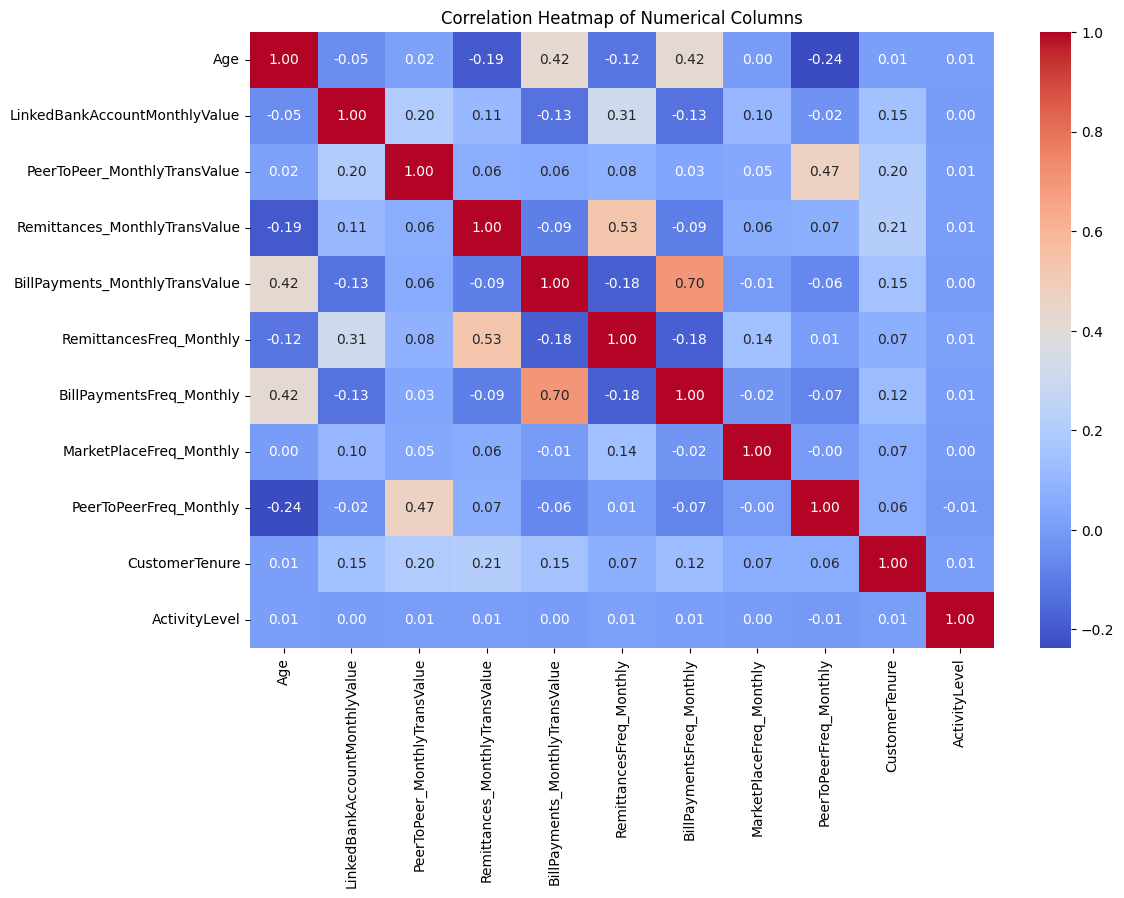

In [6]:
# Assuming gkone_data is already loaded and preprocessed

def plot_correlation_heatmap(data):
    # Select only numerical columns
    numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

    # Calculate the correlation matrix
    corr_matrix = data[numerical_cols].corr()

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap of Numerical Columns")
    plt.show()

# Call the function
plot_correlation_heatmap(gkone_datacopy)

This Numerical Data shows that BillPaymentsFreq_Monthly (0.70) has a Strong positive correlation with BillPayments_MonthlyTransValue. This indicates that customers who frequently pay bills tend to have higher bill payment transaction values

There is a moderate relationship between PeerToPeerFreq_Monthly and PeerToPeer_MonthlyTransValue, indicating that customers who frequently engage in peer to peer transactions tend to somewhat have higher Peer Transaction Values.

# Population Age Groups Breakdown

In [7]:
# Step 1: Classify Age Groups by Percentile

def classify_age_groups(data):
    # Calculate the percentiles
    percentiles = np.percentile(data['Age'], [25, 50, 75])

    # Create a function to classify age into percentiles
    def age_group(age):
        if age <= percentiles[0]:
            return '0-25th Percentile'
        elif age <= percentiles[1]:
            return '25th-50th Percentile'
        elif age <= percentiles[2]:
            return '50th-75th Percentile'
        else:
            return '75th-100th Percentile'

    # Apply the function to classify ages
    data['AgeGroup'] = data['Age'].apply(age_group)
    return data

# Call the function and update gkone_datacopy
gkone_datacopy = classify_age_groups(gkone_datacopy)

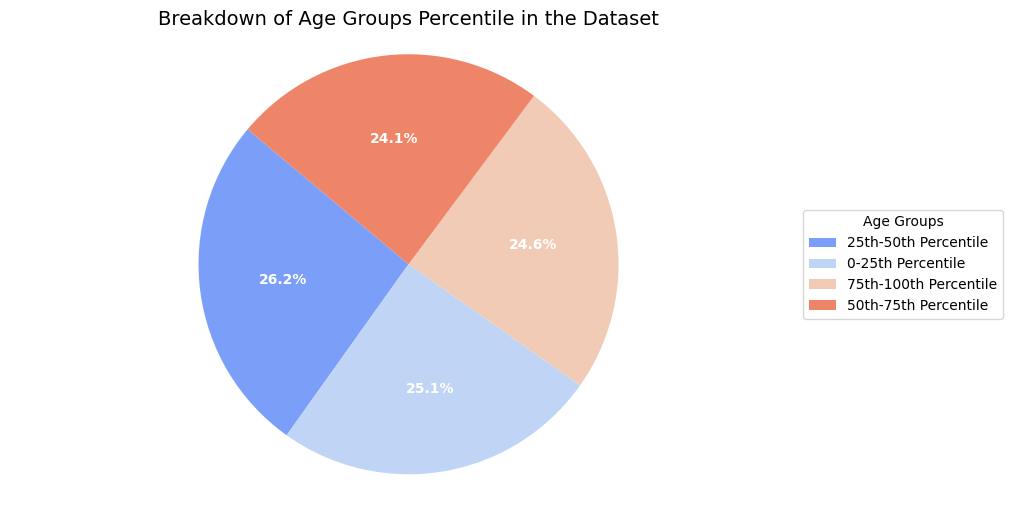

In [8]:
def plot_age_group_pie_chart(data):
    age_group_counts = data['AgeGroup'].value_counts()

    # Plot the pie chart with enhancements
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("coolwarm", len(age_group_counts))
    wedges, texts, autotexts = plt.pie(
        age_group_counts,
        labels=age_group_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        textprops=dict(color="w")
    )

    # Enhance the appearance
    plt.setp(autotexts, size=10, weight="bold")
    plt.setp(texts, size=12)
    plt.title('Breakdown of Age Groups Percentile in the Dataset', fontsize=14)

    # Add a legend
    plt.legend(wedges, age_group_counts.index, title="Age Groups", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    # Equal aspect ratio ensures the pie chart is circular
    plt.axis('equal')
    plt.show()

# Classify age groups
gkone_datacopy = classify_age_groups(gkone_datacopy)

# Plot the enhanced pie chart
plot_age_group_pie_chart(gkone_datacopy)

This shows that the majority of the population in the dataset is within the 25th-50th percentile which represents customers between the ages of 28-37 year old.

The 2nd highest percentile of ages are within the ages of 18-27 years old and the other groups 50th-75th Percentile Age Range: 38 years - 48 years
and 75th-100th Percentile Age Range: 49 - 69 years.

Does Age Percentiles influences Product Types that a customer chooses?

In [9]:
# Step 1: One Hot Encode the New Age Quartile Columns

# One-hot encode the new quartile columns
age_group_dummies = pd.get_dummies(gkone_datacopy['AgeGroup'], prefix='AgeGroup')

# Convert boolean to integers (0 and 1)
age_group_dummies = age_group_dummies.astype(int)

# Concatenate the one-hot encoded age groups back to the original dataframe
gkone_datacopy = pd.concat([gkone_datacopy, age_group_dummies], axis=1)

# Drop the original AgeGroup and Age columns
gkone_datacopy.drop(columns=['AgeGroup', 'Age'], inplace=True)

In [10]:
# Step 2: One Hot Encode the ProductType Column

product_types = gkone_datacopy['ProductType'].apply(lambda x: x.strip('[]').replace("'", "").split(', '))
product_type_dummies = product_types.str.join('|').str.get_dummies()

# Concatenate the one-hot encoded product types back to the original dataframe
gkone_datacopy = pd.concat([gkone_datacopy, product_type_dummies], axis=1)

# Drop the original ProductType column
gkone_datacopy.drop(columns=['ProductType'], inplace=True)

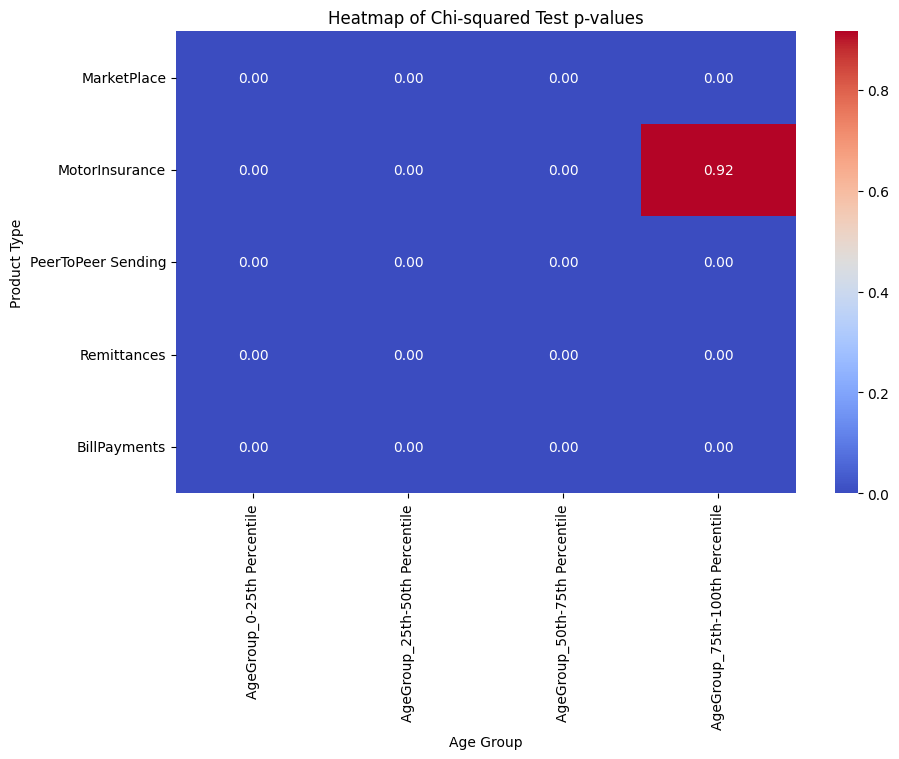

In [11]:
products = ['MarketPlace', 'MotorInsurance', 'PeerToPeer Sending', 'Remittances', 'BillPayments']
age_groups = ['AgeGroup_0-25th Percentile', 'AgeGroup_25th-50th Percentile', 'AgeGroup_50th-75th Percentile', 'AgeGroup_75th-100th Percentile']

# Function to perform chi-squared test and prepare data for heatmap
def chi_squared_heatmap_data(data, products, age_groups):
    heatmap_data = pd.DataFrame(index=products, columns=age_groups)

    for product in products:
        for age_group in age_groups:
            # Create a contingency table
            contingency_table = pd.crosstab(data[product], data[age_group])

            # Perform chi-squared test
            chi2, p, _, _ = chi2_contingency(contingency_table)

            # Store p-value in the heatmap data
            heatmap_data.loc[product, age_group] = p

    # Convert to float for heatmap
    heatmap_data = heatmap_data.astype(float)

    return heatmap_data

# Perform the chi-squared test and prepare heatmap data
heatmap_data = chi_squared_heatmap_data(gkone_datacopy, products, age_groups)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Chi-squared Test p-values')
plt.xlabel('Age Group')
plt.ylabel('Product Type')
plt.show()

The heatmap reveals significant relationships between most product types and all the specified age groups. This is highlighed by the fact that the p-value is less than 0.05. Therefore, there is evidence that most of the Age Groups are associated with all the ProductTypes.

The only exception is customers within the age group of 49 - 69 years and we don't find a statistical significance between them and MotorInsurance. This shows that older persons are not really correlated with taking out MotorInsurance.

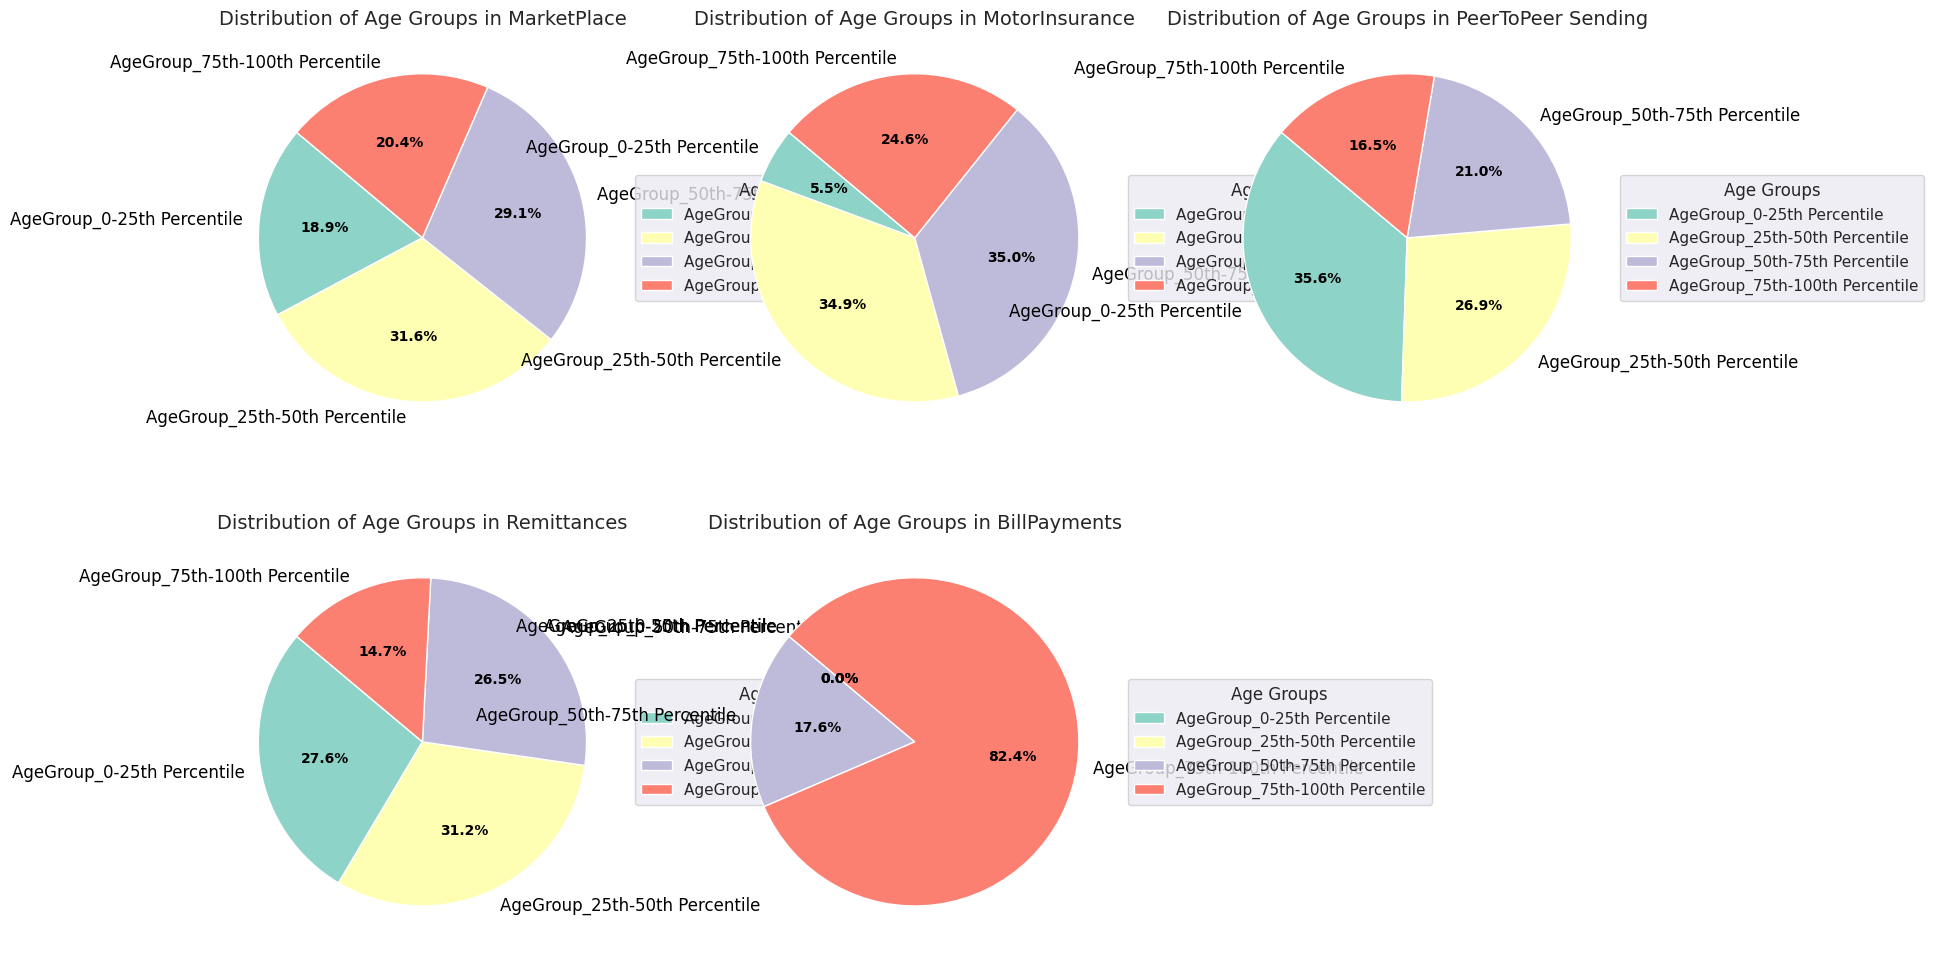

In [12]:
import seaborn as sns
sns.set()

def plot_product_agegroup_distribution(data, products, age_groups):
    plt.figure(figsize=(18, 12))

    for i, product in enumerate(products):
        plt.subplot(2, 3, i + 1)
        product_data = data[data[product] == 1]  # Filter data for the specific product
        age_group_counts = product_data[age_groups].sum()

        # Plot the pie chart
        wedges, texts, autotexts = plt.pie(
            age_group_counts,
            labels=age_group_counts.index,
            autopct='%1.1f%%',
            startangle=140,
            colors=sns.color_palette("Set3"),
            textprops=dict(color="black")
        )

        # Enhance the appearance
        plt.setp(autotexts, size=10, weight="bold")
        plt.setp(texts, size=12)
        plt.title(f'Distribution of Age Groups in {product}', fontsize=14)

        # Add a legend outside the plot
        plt.legend(wedges, age_group_counts.index, title="Age Groups", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    plt.tight_layout(pad=3.0)
    plt.show()

# Call the function
products = ['MarketPlace', 'MotorInsurance', 'PeerToPeer Sending', 'Remittances', 'BillPayments']
age_groups = ['AgeGroup_0-25th Percentile', 'AgeGroup_25th-50th Percentile', 'AgeGroup_50th-75th Percentile', 'AgeGroup_75th-100th Percentile']

plot_product_agegroup_distribution(gkone_datacopy, products, age_groups)


Based on these visualizations, we can see that the populations between the age groups 28-37 years are the largest groups for the MarketPlace Services. They enjoy taking advantage of the Product Deals on Amazon and Shopping on HiLo Online Platform.

The Age Groups ranging between 38 years to 48 years - which makes up the 50th-75th percentile are the largest users for MotorInsurance.

The Age Groups ranging between 18-27 years old are the largest groups for Peer to Peer Transactions. Lastly, the Age Groups ranging between 49-69 years are the biggest users of the Bill Payment Services. Most of them (82.4%) of the population rely on the GKONE app to make payments towards their bills.


## ANOVA Test

### Differences in means across the MonthlyTransValue columns.

In [13]:
# Step 1 : Min-Max Scale the specified columns
from sklearn.preprocessing import MinMaxScaler

columns_to_scale = [
    'RemittancesFreq_Monthly', 'BillPaymentsFreq_Monthly', 'MarketPlaceFreq_Monthly',
    'PeerToPeerFreq_Monthly', 'CustomerTenure', 'ActivityLevel'
]

# Fit and transform the selected columns
scaler = MinMaxScaler()
gkone_datacopy[columns_to_scale] = scaler.fit_transform(gkone_datacopy[columns_to_scale])

In [14]:
def normalize(data):
    # One-hot encode categorical columns and convert to int
    categorical_cols = ['Gender', 'EmploymentStatus']
    for col in categorical_cols:
        if col in data.columns:
            dummies = pd.get_dummies(data[col], prefix=col)
            dummies = dummies.astype(int)  # Convert to int
            data = pd.concat([data, dummies], axis=1)
            data.drop(columns=[col], inplace=True)

    # Standardize numerical columns
    numerical_cols = ['Remittances_MonthlyTransValue', 'BillPayments_MonthlyTransValue', 'PeerToPeer_MonthlyTransValue', 'LinkedBankAccountMonthlyValue']
    scaler = StandardScaler()
    data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

    # Convert boolean to 0 and 1 for encoded columns
    encoded_cols = [col for col in data.columns if data[col].dtype == 'bool']
    data[encoded_cols] = data[encoded_cols].astype(int)

    return data

gkone_datacopy = normalize(gkone_datacopy)
print(gkone_datacopy.head())

      CustomerID       Location  LinkedBankAccountMonthlyValue  \
0  sdv-id-IN7ITT       Trelawny                      -0.137452   
1  sdv-id-4hnCCT  St. Catherine                       0.245979   
2  sdv-id-iOIToj     St. Andrew                       0.884365   
3  sdv-id-8TvnUL       Kingston                      -0.657492   
4  sdv-id-QijYGa     St. Andrew                      -0.128371   

   PeerToPeer_MonthlyTransValue  Remittances_MonthlyTransValue  \
0                     -0.324225                       0.357326   
1                      2.118634                       2.378202   
2                      0.298235                       0.627340   
3                     -0.869801                      -1.091206   
4                     -0.072065                      -1.091206   

   BillPayments_MonthlyTransValue  RemittancesFreq_Monthly  \
0                       -0.330086                 0.516667   
1                       -0.330086                 0.933333   
2                   

# MONETARY VALUE Analysis

## ANOVA TEST

***Is there a relationship between all the categories of Income Level and BillPayments Transaction Values?***

Null Hypothesis: The means of all the Bill Payments transaction values across the different income levels (High, Mid, Low) are the same.

Alternative Hypothesis: The means of all the Bill Payment transaction values across the different income levels (High, Mid, Low) are NOT the same.


In [15]:
# One-hot encode the IncomeLevel column
income_level_encoded = pd.get_dummies(gkone_datacopy['IncomeLevel'], prefix='IncomeLevel')

# Convert True/False to 1/0
income_level_encoded = income_level_encoded.astype(int)

# Concatenate the one-hot encoded columns back to the original dataframe
gkone_datacopy = pd.concat([gkone_datacopy, income_level_encoded], axis=1)

# Drop the original IncomeLevel column
gkone_datacopy.drop(columns=['IncomeLevel'], inplace=True)

# Display the first few rows to verify
print(gkone_datacopy.head())

      CustomerID       Location  LinkedBankAccountMonthlyValue  \
0  sdv-id-IN7ITT       Trelawny                      -0.137452   
1  sdv-id-4hnCCT  St. Catherine                       0.245979   
2  sdv-id-iOIToj     St. Andrew                       0.884365   
3  sdv-id-8TvnUL       Kingston                      -0.657492   
4  sdv-id-QijYGa     St. Andrew                      -0.128371   

   PeerToPeer_MonthlyTransValue  Remittances_MonthlyTransValue  \
0                     -0.324225                       0.357326   
1                      2.118634                       2.378202   
2                      0.298235                       0.627340   
3                     -0.869801                      -1.091206   
4                     -0.072065                      -1.091206   

   BillPayments_MonthlyTransValue  RemittancesFreq_Monthly  \
0                       -0.330086                 0.516667   
1                       -0.330086                 0.933333   
2                   

In [16]:
# Perform ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols

def perform_anova(data, transaction_column, category_columns):
    for category_column in category_columns:
        model = ols(f'{transaction_column} ~ C({category_column})', data=data).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print(f'ANOVA result for {transaction_column} by {category_column}:\n')
        print(anova_table)
        print('\n')

# Define the one-hot encoded columns
category_columns = ['IncomeLevel_High', 'IncomeLevel_Low', 'IncomeLevel_Medium']

# Perform ANOVA for BillPayments_MonthlyTransValue
perform_anova(gkone_datacopy, 'BillPayments_MonthlyTransValue', category_columns)

ANOVA result for BillPayments_MonthlyTransValue by IncomeLevel_High:

                           sum_sq       df         F    PR(>F)
C(IncomeLevel_High)      0.001444      1.0  0.001444  0.969689
Residual             29999.998556  29998.0       NaN       NaN


ANOVA result for BillPayments_MonthlyTransValue by IncomeLevel_Low:

                          sum_sq       df         F    PR(>F)
C(IncomeLevel_Low)      0.026985      1.0  0.026983  0.869523
Residual            29999.973015  29998.0       NaN       NaN


ANOVA result for BillPayments_MonthlyTransValue by IncomeLevel_Medium:

                             sum_sq       df         F    PR(>F)
C(IncomeLevel_Medium)      0.038165      1.0  0.038162  0.845119
Residual               29999.961835  29998.0       NaN       NaN




*These results show that there are not any statistically significant differences in BillPayments_MonthlyTransValue across the different income levels (High, Low, and Medium). This is shown by the p-value scores PR(>F) in the regard that they are higher than 0.05. This shows that the means for them are equal and not different.*

***Is there a relationship between all the categories of Income Level and PeerToPeer Transaction Values?***

Null Hypothesis: The means of all the PeerToPeer transaction values across the different income levels (High, Mid, Low) are the same.

Alternative Hypothesis: The means of all the PeerToPeer transaction values across the different income levels (High, Mid, Low) are NOT the same.


In [17]:
# Perform ANOVA

def perform_anova(data, transaction_column, category_columns):
    for category_column in category_columns:
        model = ols(f'{transaction_column} ~ C({category_column})', data=data).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print(f'ANOVA result for {transaction_column} by {category_column}:\n')
        print(anova_table)
        print('\n')

# Define the one-hot encoded columns
category_columns = ['IncomeLevel_High', 'IncomeLevel_Low', 'IncomeLevel_Medium']

# Perform ANOVA for PeerToPeer_MonthlyTransValue
perform_anova(gkone_datacopy, 'PeerToPeer_MonthlyTransValue', category_columns)

ANOVA result for PeerToPeer_MonthlyTransValue by IncomeLevel_High:

                           sum_sq       df           F  PR(>F)
C(IncomeLevel_High)   3332.892866      1.0  3749.19258     0.0
Residual             26667.107134  29998.0         NaN     NaN


ANOVA result for PeerToPeer_MonthlyTransValue by IncomeLevel_Low:

                          sum_sq       df            F  PR(>F)
C(IncomeLevel_Low)   5051.057858      1.0  6073.268869     0.0
Residual            24948.942142  29998.0          NaN     NaN


ANOVA result for PeerToPeer_MonthlyTransValue by IncomeLevel_Medium:

                             sum_sq       df           F         PR(>F)
C(IncomeLevel_Medium)    572.815298      1.0  583.926511  8.759556e-128
Residual               29427.184702  29998.0         NaN            NaN




*Based on these scores for the PR(>F) values ...*

*These results suggest that income levels have a significant impact on PeerToPeer_MonthlyTransValue. This means that customers' peer-to-peer transaction values are different across income levels, with each income level showing significant differences compared to others.*

*This shows that Income Level do have an impact on the amount of money that the customers send through the platform. The p-values are lower than 0.05, which means that we will reject the null hypothesis and conclude that there is evidence that the means are indeed different*

***Is there a relationship between all the categories of Income Level and Remittances_MonthlyTransValue?***

Null Hypothesis: The means of all the Remittances_MonthlyTransValue across the different income levels (High, Mid, Low) are the same.

Alternative Hypothesis: The means of all the Remittances_MonthlyTransValue across the different income levels (High, Mid, Low) are NOT the same.

In [18]:
# Perform ANOVA

def perform_anova(data, transaction_column, category_columns):
    for category_column in category_columns:
        model = ols(f'{transaction_column} ~ C({category_column})', data=data).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print(f'ANOVA result for {transaction_column} by {category_column}:\n')
        print(anova_table)
        print('\n')

# Define the one-hot encoded columns
category_columns = ['IncomeLevel_High', 'IncomeLevel_Low', 'IncomeLevel_Medium']

# Perform ANOVA for Remittances_MonthlyTransValue
perform_anova(gkone_datacopy, 'Remittances_MonthlyTransValue', category_columns)

ANOVA result for Remittances_MonthlyTransValue by IncomeLevel_High:

                           sum_sq       df         F    PR(>F)
C(IncomeLevel_High)      0.779914      1.0  0.779882  0.377184
Residual             29999.220086  29998.0       NaN       NaN


ANOVA result for Remittances_MonthlyTransValue by IncomeLevel_Low:

                          sum_sq       df       F    PR(>F)
C(IncomeLevel_Low)      0.097406      1.0  0.0974  0.754974
Residual            29999.902594  29998.0     NaN       NaN


ANOVA result for Remittances_MonthlyTransValue by IncomeLevel_Medium:

                             sum_sq       df         F    PR(>F)
C(IncomeLevel_Medium)      0.167432      1.0  0.167421  0.682417
Residual               29999.832568  29998.0       NaN       NaN




*These results show that there are not any statistically significant differences in Remittances_MonthlyTransValue across the different income levels (High, Low, and Medium). This is shown by the p-value scores PR(>F) in the regard that they are higher than 0.05. This shows that the means for them are equal and not different.*

In [19]:
gkone_datacopy.head()

,CustomerID,Location,LinkedBankAccountMonthlyValue,PeerToPeer_MonthlyTransValue,Remittances_MonthlyTransValue,BillPayments_MonthlyTransValue,RemittancesFreq_Monthly,BillPaymentsFreq_Monthly,MarketPlaceFreq_Monthly,PeerToPeerFreq_Monthly,...,Remittances,Gender_Female,Gender_Male,EmploymentStatus_Employed,EmploymentStatus_Retired,EmploymentStatus_Student,EmploymentStatus_Unemployed,IncomeLevel_High,IncomeLevel_Low,IncomeLevel_Medium
0,sdv-id-IN7ITT,Trelawny,-0.137452,-0.324225,0.357326,-0.330086,0.516667,0.0,0.473684,0.210526,...,1,1,0,1,0,0,0,0,1,0
1,sdv-id-4hnCCT,St. Catherine,0.245979,2.118634,2.378202,-0.330086,0.933333,0.0,0.368421,0.368421,...,1,1,0,0,0,1,0,0,0,1
2,sdv-id-iOIToj,St. Andrew,0.884365,0.298235,0.627340,-0.330086,0.683333,0.0,0.000000,0.263158,...,1,1,0,1,0,0,0,0,1,0
3,sdv-id-8TvnUL,Kingston,-0.657492,-0.869801,-1.091206,-0.330086,0.000000,0.0,0.000000,0.105263,...,0,0,1,0,0,0,1,0,1,0
4,sdv-id-QijYGa,St. Andrew,-0.128371,-0.072065,-1.091206,-0.330086,0.000000,0.0,0.000000,0.368421,...,0,1,0,1,0,0,0,0,0,1


Categories Per Location


Counts for BillPayments:
Location
Clarendon        293
Hanover          260
Kingston         258
Manchester       265
Portland         259
St. Andrew       276
St. Ann          299
St. Catherine    270
St. Elizabeth    282
St. James        321
St. Mary         296
St. Thomas       320
Trelawny         267
Westmoreland     316
Name: count, dtype: int64


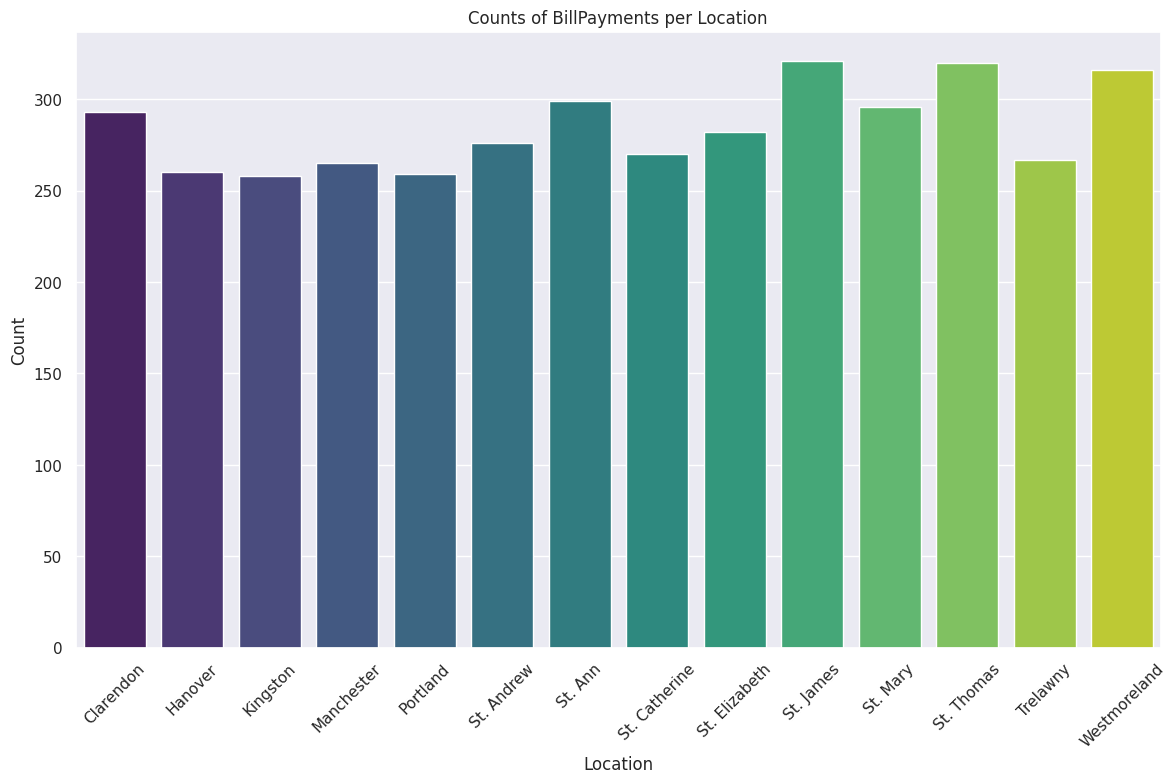

In [20]:
# Function to count categories per location
def count_categories_per_location(data, category):
    # Filter the data for the specified category
    category_data = data[data[category] == 1]

    # Count the occurrences per location
    location_counts = category_data['Location'].value_counts().sort_index()

    return location_counts

# Count `BillPayments` per location
bill_payments_counts = count_categories_per_location(gkone_datacopy, 'BillPayments')

# Display counts for verification
print(f"\nCounts for BillPayments:\n{bill_payments_counts}")

# Function to plot counts per location for a specified category
def plot_counts_per_location(data, category):
    plt.figure(figsize=(14, 8))
    sns.barplot(x=data.index, y=data.values, palette='viridis')
    plt.title(f'Counts of {category} per Location')
    plt.xlabel('Location')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# Plot counts for BillPayments
plot_counts_per_location(bill_payments_counts, 'BillPayments')


Counts for PeerToPeer Sending:
Location
Clarendon         751
Hanover           682
Kingston         3788
Manchester        703
Portland          699
St. Andrew       3804
St. Ann           732
St. Catherine    3816
St. Elizabeth     690
St. James         696
St. Mary          692
St. Thomas        718
Trelawny          714
Westmoreland      726
Name: count, dtype: int64


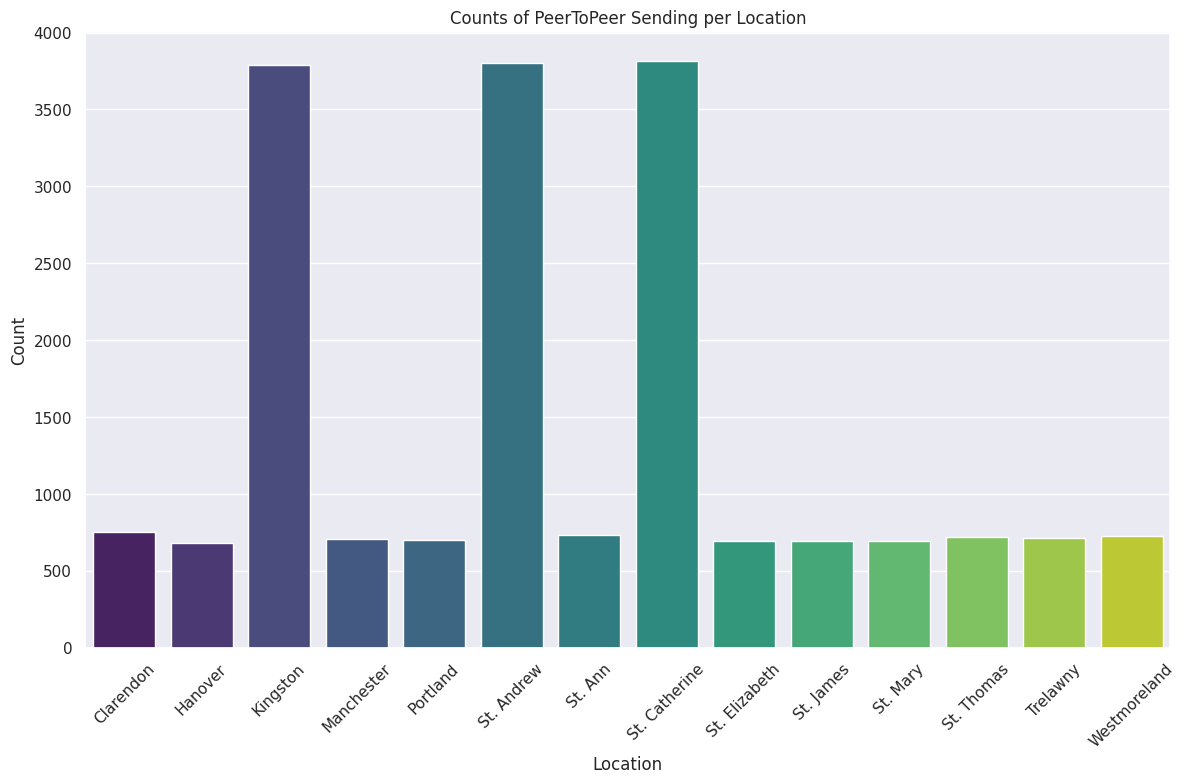

In [21]:
# Count `PeerToPeer Sending` per location
peer_to_peer_counts = count_categories_per_location(gkone_datacopy, 'PeerToPeer Sending')

# Display counts for verification
print(f"\nCounts for PeerToPeer Sending:\n{peer_to_peer_counts}")

# Plot counts for PeerToPeer Sending
plot_counts_per_location(peer_to_peer_counts, 'PeerToPeer Sending')


Counts for MotorInsurance:
Location
Clarendon         541
Hanover           534
Kingston         2417
Manchester        554
Portland          509
St. Andrew       2435
St. Ann           544
St. Catherine    2366
St. Elizabeth     555
St. James         577
St. Mary          568
St. Thomas        551
Trelawny          531
Westmoreland      586
Name: count, dtype: int64


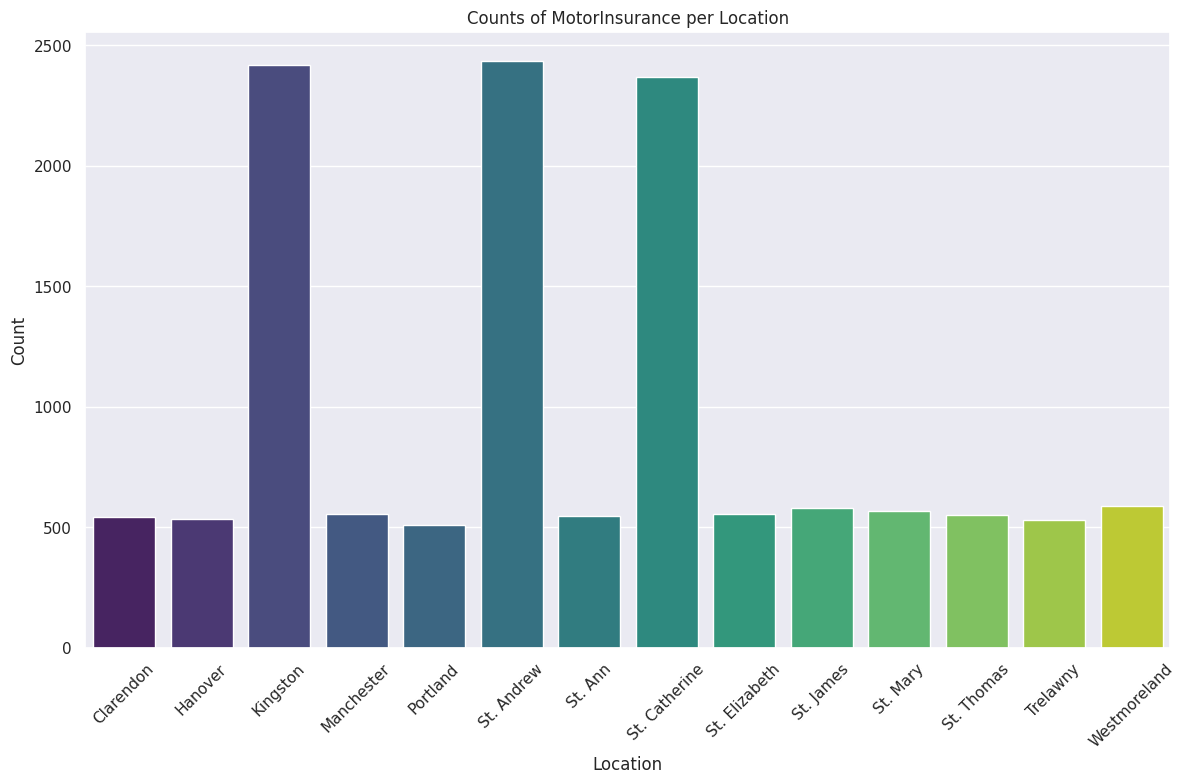

In [22]:
# Count `Motor Insurance` per location
MotorInsurance_counts = count_categories_per_location(gkone_datacopy, 'MotorInsurance')

# Display counts for verification
print(f"\nCounts for MotorInsurance:\n{MotorInsurance_counts}")

# Plot counts for Motor Insurance
plot_counts_per_location(MotorInsurance_counts, 'MotorInsurance')


Counts for MarketPlace :
Location
Clarendon         621
Hanover           628
Kingston         2972
Manchester        619
Portland          603
St. Andrew       3030
St. Ann           639
St. Catherine    3014
St. Elizabeth     615
St. James         662
St. Mary          654
St. Thomas        629
Trelawny          644
Westmoreland      634
Name: count, dtype: int64


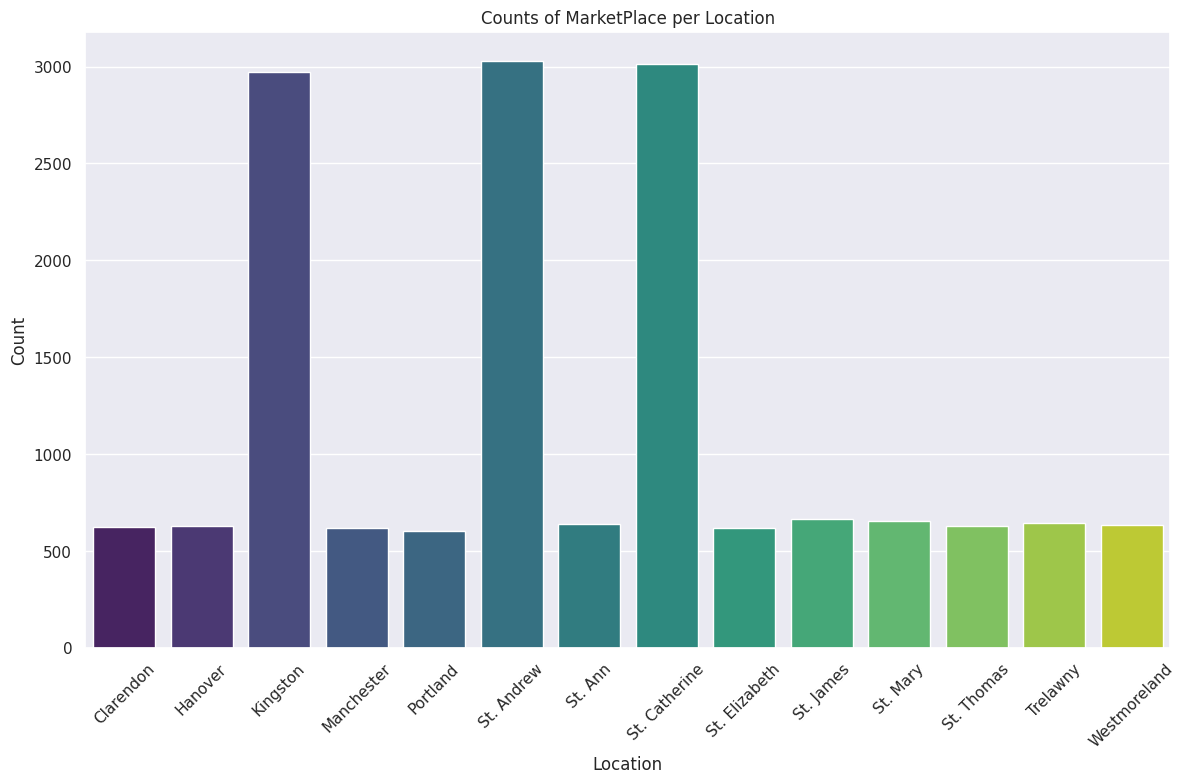

In [23]:
# Count `MarketPlace` per location
MarketPlace_counts = count_categories_per_location(gkone_datacopy, 'MarketPlace')

# Display counts for verification
print(f"\nCounts for MarketPlace :\n{MarketPlace_counts}")

# Plot counts for Motor Insurance
plot_counts_per_location(MarketPlace_counts, 'MarketPlace')


Counts for Remittances :
Location
Clarendon         800
Hanover           809
Kingston         4427
Manchester        775
Portland          789
St. Andrew       4441
St. Ann           801
St. Catherine    4382
St. Elizabeth     789
St. James         818
St. Mary          810
St. Thomas        803
Trelawny          803
Westmoreland      831
Name: count, dtype: int64


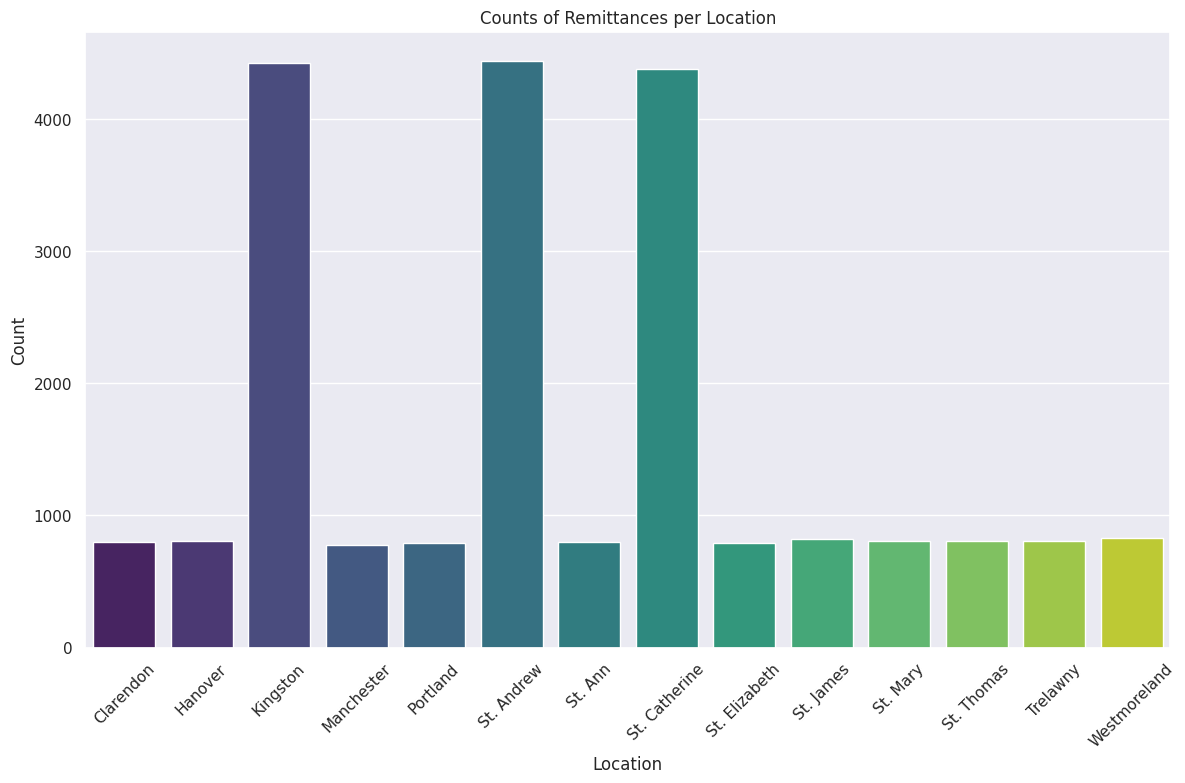

In [24]:
# Count `Remittances` per location
Remittances_counts = count_categories_per_location(gkone_datacopy, 'Remittances')

# Display counts for verification
print(f"\nCounts for Remittances :\n{Remittances_counts}")

# Plot counts for Remittances
plot_counts_per_location(Remittances_counts, 'Remittances')

Based on these scores, we can see that the parishes for Kingston, St. Andrew and St. Catherine are the parishes where the most interactions for the App services are coming from. The only exception is for the category of Bill Payments per location, where we see the parishes of St. James, St. Thomas and Westmoreland having the highest represention for the bill Payment aspect of the app.

We will classify the parishes into Top, Mid and low for each product category.

In [25]:
# Define top parishes for each category
top_parishes = {
    'Remittances': ['Kingston', 'St. Andrew', 'St. Catherine'],
    'MarketPlace': ['Kingston', 'St. Andrew', 'St. Catherine'],
    'MotorInsurance': ['Kingston', 'St. Andrew', 'St. Catherine'],
    'PeerToPeer Sending': ['Kingston', 'St. Andrew', 'St. Catherine'],
    'BillPayments': ['St. James', 'St. Thomas', 'Westmoreland']
}

# Function to classify locations based on predefined top parishes and ranking
def classify_location(parish, category, counts):
    if parish in top_parishes[category]:
        return 'Top'
    else:
        sorted_counts = counts.sort_values(ascending=False)
        mid_cutoff = int(len(sorted_counts) * 0.5)  # Mid is the next 50% after Top
        low_cutoff = len(sorted_counts)  # Remaining are Low

        if parish in sorted_counts.index[:mid_cutoff]:
            return 'Mid'
        else:
            return 'Low'

# Apply the classification to each category count
def classify_parish_counts(counts, category):
    classified_counts = counts.index.to_series().apply(lambda parish: classify_location(parish, category, counts))
    return classified_counts

# Count and classify for each category
categories = ['Remittances', 'MarketPlace', 'MotorInsurance', 'PeerToPeer Sending', 'BillPayments']
location_category_counts = {}

for category in categories:
    location_category_counts[category] = count_categories_per_location(gkone_datacopy, category)
    location_category_counts[category] = classify_parish_counts(location_category_counts[category], category)

In [26]:
# Create a mapping of parishes to their overall classification
parish_classification_mapping = pd.DataFrame(index=gkone_datacopy['Location'].unique())

for category in categories:
    parish_classification_mapping[category] = parish_classification_mapping.index.map(location_category_counts[category].to_dict())

# Determine overall classification for each parish
def determine_overall_classification(row):
    if 'Top' in row.values:
        return 'Top'
    elif 'Mid' in row.values:
        return 'Mid'
    else:
        return 'Low'

parish_classification_mapping['Overall_Classification'] = parish_classification_mapping.apply(determine_overall_classification, axis=1)

# Display the mapping to verify
print(parish_classification_mapping.head())

              Remittances MarketPlace MotorInsurance PeerToPeer Sending  \
Trelawny              Low         Mid            Low                Low   
St. Catherine         Top         Top            Top                Top   
St. Andrew            Top         Top            Top                Top   
Kingston              Top         Top            Top                Top   
St. Elizabeth         Low         Low            Mid                Low   

              BillPayments Overall_Classification  
Trelawny               Low                    Mid  
St. Catherine          Low                    Top  
St. Andrew             Low                    Top  
Kingston               Low                    Top  
St. Elizabeth          Mid                    Mid  


In [27]:
# Map the overall classification to the original dataset
gkone_datacopy['Overall_Classification'] = gkone_datacopy['Location'].map(parish_classification_mapping['Overall_Classification'])

# One-hot encode the Overall_Classification column
overall_classification_encoded = pd.get_dummies(gkone_datacopy['Overall_Classification'], prefix='Usage')

# Rename the columns to more concise names
overall_classification_encoded.columns = ['High_Usage_Location', 'Moderate_Usage_Location', 'Low_Usage_Location']

# Convert True/False to 1/0
overall_classification_encoded = overall_classification_encoded.astype(int)

# Concatenate the one-hot encoded columns back to the original dataframe
gkone_datacopy = pd.concat([gkone_datacopy, overall_classification_encoded], axis=1)

# Drop the original classification columns and the Overall_Classification column
gkone_datacopy.drop(columns=['Overall_Classification','Location'], inplace=True)


### ANOVA Test for Education Level and BillPayments_MonthlyTransValue

***Is there a relationship between all the categories of EducationLevel and BillPayments Transaction Values?***

Null Hypothesis: The means of all the Bill Payments transaction values across the different Education levels (High School, College, Graduate) are the same.

Alternative Hypothesis: The means of all the Bill Payments transaction values across the different Education levels (High School, College, Graduate) are NOT the same.





In [28]:
# One-hot encode the EducationLevel column
education_level_encoded = pd.get_dummies(gkone_datacopy['EducationLevel'], prefix='EducationLevel')

# Convert True/False to 1/0
education_level_encoded = education_level_encoded.astype(int)

# Concatenate the one-hot encoded columns back to the original dataframe
gkone_datacopy = pd.concat([gkone_datacopy, education_level_encoded], axis=1)

# Drop the original EducationLevel column
gkone_datacopy.drop(columns=['EducationLevel'], inplace=True)

In [29]:
# Replace spaces with underscores in column names
gkone_datacopy.columns = gkone_datacopy.columns.str.replace(' ', '_')

# Define the one-hot encoded columns
category_columns = ['EducationLevel_College', 'EducationLevel_Graduate', 'EducationLevel_High_School']

# Perform ANOVA
def perform_anova(data, transaction_column, category_columns):
    for category_column in category_columns:
        model = ols(f'{transaction_column} ~ C({category_column})', data=data).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print(f'ANOVA result for {transaction_column} by {category_column}:\n')
        print(anova_table)
        print('\n')

# Perform ANOVA for BillPayments_MonthlyTransValue
perform_anova(gkone_datacopy, 'BillPayments_MonthlyTransValue', category_columns)

ANOVA result for BillPayments_MonthlyTransValue by EducationLevel_College:

                                 sum_sq       df         F    PR(>F)
C(EducationLevel_College)      0.811601      1.0  0.811569  0.367664
Residual                   29999.188399  29998.0       NaN       NaN


ANOVA result for BillPayments_MonthlyTransValue by EducationLevel_Graduate:

                                  sum_sq       df         F    PR(>F)
C(EducationLevel_Graduate)      2.523675      1.0  2.523719  0.112156
Residual                    29997.476325  29998.0       NaN       NaN


ANOVA result for BillPayments_MonthlyTransValue by EducationLevel_High_School:

                                     sum_sq       df         F    PR(>F)
C(EducationLevel_High_School)      0.161258      1.0  0.161248  0.688013
Residual                       29999.838742  29998.0       NaN       NaN




Based on the results for this. We see that the means for the categories of EducationLevel.  Essentially, customers with different education levels (College, Graduate, High School) have similar average values for BillPayments_MonthlyTransValue.

### ANOVA Test for Education Level and PeerToPeer_MonthlyTransValue

***Is there a relationship between all the categories of EducationLevel and Peer To Peer Transaction Values?***

Null Hypothesis: The means of all the Peer to Peer Payments transaction values across the different Education levels (High School, College, Graduate) are the same.

Alternative Hypothesis: The means of all the Peer To Peer transaction values across the different Education levels (High School, College, Graduate) are NOT the same.

In [30]:
# Replace spaces with underscores in column names
gkone_datacopy.columns = gkone_datacopy.columns.str.replace(' ', '_')

# Define the one-hot encoded columns
category_columns = ['EducationLevel_College', 'EducationLevel_Graduate', 'EducationLevel_High_School']

# Perform ANOVA
def perform_anova(data, transaction_column, category_columns):
    for category_column in category_columns:
        model = ols(f'{transaction_column} ~ C({category_column})', data=data).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print(f'ANOVA result for {transaction_column} by {category_column}:\n')
        print(anova_table)
        print('\n')

# Perform ANOVA for PeerToPeer_MonthlyTransValue
perform_anova(gkone_datacopy, 'PeerToPeer_MonthlyTransValue', category_columns)

ANOVA result for PeerToPeer_MonthlyTransValue by EducationLevel_College:

                                sum_sq       df         F    PR(>F)
C(EducationLevel_College)      5.12644      1.0  5.126974  0.023564
Residual                   29994.87356  29998.0       NaN       NaN


ANOVA result for PeerToPeer_MonthlyTransValue by EducationLevel_Graduate:

                                  sum_sq       df         F   PR(>F)
C(EducationLevel_Graduate)      0.517282      1.0  0.517257  0.47202
Residual                    29999.482718  29998.0       NaN      NaN


ANOVA result for PeerToPeer_MonthlyTransValue by EducationLevel_High_School:

                                     sum_sq       df         F    PR(>F)
C(EducationLevel_High_School)      2.806629      1.0  2.806705  0.093881
Residual                       29997.193371  29998.0       NaN       NaN




### ANOVA Test for Education Level and Remittances_MonthlyTransValue

***Is there a relationship between all the categories of EducationLevel and Remittances Transaction Values?***

Null Hypothesis: The means of all the Remittances transaction values across the different Education levels (High School, College, Graduate) are the same.

Alternative Hypothesis: The means of all the Remittances transaction values across the different Education levels (High School, College, Graduate) are NOT the same.

In [31]:
# Replace spaces with underscores in column names
gkone_datacopy.columns = gkone_datacopy.columns.str.replace(' ', '_')

# Define the one-hot encoded columns
category_columns = ['EducationLevel_College', 'EducationLevel_Graduate', 'EducationLevel_High_School']


# Perform ANOVA for PeerToPeer_MonthlyTransValue
perform_anova(gkone_datacopy, 'Remittances_MonthlyTransValue', category_columns)

ANOVA result for Remittances_MonthlyTransValue by EducationLevel_College:

                                 sum_sq       df         F   PR(>F)
C(EducationLevel_College)      1.782615      1.0  1.782602  0.18184
Residual                   29998.217385  29998.0       NaN      NaN


ANOVA result for Remittances_MonthlyTransValue by EducationLevel_Graduate:

                                  sum_sq       df         F    PR(>F)
C(EducationLevel_Graduate)      0.164904      1.0  0.164894  0.684693
Residual                    29999.835096  29998.0       NaN       NaN


ANOVA result for Remittances_MonthlyTransValue by EducationLevel_High_School:

                                     sum_sq       df         F    PR(>F)
C(EducationLevel_High_School)      1.005386      1.0  1.005353  0.316027
Residual                       29998.994614  29998.0       NaN       NaN




Based on the results for this. We see that the means for the categories of EducationLevel.  Essentially, customers with different education levels (College, Graduate, High School) have similar average values for Remittances Payments.
This means that a customer's education level doesn't have any impact on their remittances transaction levels.

Further Feature Engineering ...

In [32]:
# Update the original gkone_data with the changes from gkone_datacopy
gkone_data = gkone_datacopy.copy()

# Drop the CustomerID column
gkone_data.drop(columns=['CustomerID'], inplace=True)

# Ensure all columns are in float32 format
gkone_data = gkone_data.astype('float32')

# Verify the changes
print(gkone_data.head())
print(gkone_data.dtypes)

# Clean up temporary dataframes
del gkone_datacopy

   LinkedBankAccountMonthlyValue  PeerToPeer_MonthlyTransValue  \
0                      -0.137452                     -0.324225   
1                       0.245979                      2.118634   
2                       0.884365                      0.298235   
3                      -0.657492                     -0.869801   
4                      -0.128371                     -0.072065   

   Remittances_MonthlyTransValue  BillPayments_MonthlyTransValue  \
0                       0.357326                       -0.330086   
1                       2.378201                       -0.330086   
2                       0.627340                       -0.330086   
3                      -1.091206                       -0.330086   
4                      -1.091206                       -0.330086   

   RemittancesFreq_Monthly  BillPaymentsFreq_Monthly  MarketPlaceFreq_Monthly  \
0                 0.516667                       0.0                 0.473684   
1                 0.933333      

# Model Training

Prioritizing Visual Representation with Reconstruction Accuracy

In [33]:
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K

# Define the input shape
input_dim = gkone_data.shape[1]  # Number of features
latent_dims = [2, 5, 10, 20]
kl_weights = [0.5, 1.0, 2.0, 4.0]  # Different KL divergence weights to test

best_reconstruction_loss = float('inf')
best_kl_weight = None
best_latent_dim = None
best_vae = None

for latent_dim in latent_dims:
    for kl_weight in kl_weights:
        # Define the VAE model with current latent_dim
        inputs = Input(shape=(input_dim,))
        h = Dense(64, activation='relu')(inputs)
        h = Dense(32, activation='relu')(h)
        z_mean = Dense(latent_dim)(h)
        z_log_var = Dense(latent_dim)(h)

        def sampling(args):
            z_mean, z_log_var = args
            batch = tf.shape(z_mean)[0]
            dim = tf.shape(z_mean)[1]
            epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon

        z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

        decoder_h1 = Dense(32, activation='relu')
        decoder_h2 = Dense(64, activation='relu')
        decoder_mean = Dense(input_dim, activation='sigmoid')
        h_decoded = decoder_h1(z)
        h_decoded = decoder_h2(h_decoded)
        x_decoded_mean = decoder_mean(h_decoded)

        vae = Model(inputs, x_decoded_mean)

        reconstruction_loss = mse(inputs, x_decoded_mean)
        reconstruction_loss *= input_dim
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        vae_loss = K.mean(reconstruction_loss + kl_weight * kl_loss)  # Adjusted KL weight

        vae.add_loss(vae_loss)
        vae.compile(optimizer='adam')

        # Train the VAE
        vae.fit(gkone_data, gkone_data, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

        # Calculate reconstruction loss
        recon_loss = vae.evaluate(gkone_data, gkone_data, verbose=0)

        if recon_loss < best_reconstruction_loss:
            best_reconstruction_loss = recon_loss
            best_kl_weight = kl_weight
            best_latent_dim = latent_dim
            best_vae = vae

# Print the best KL weight and latent dimension
print(f'Best KL Weight: {best_kl_weight}, Best Latent Dimension: {best_latent_dim}')

Best KL Weight: 0.5, Best Latent Dimension: 5


In [34]:
# Train the final VAE with the optimal latent_dim and KL weight
inputs = Input(shape=(input_dim,))
h = Dense(64, activation='relu')(inputs)
h = Dense(32, activation='relu')(h)
z_mean = Dense(best_latent_dim)(h)
z_log_var = Dense(best_latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(best_latent_dim,))([z_mean, z_log_var])

decoder_h1 = Dense(32, activation='relu')
decoder_h2 = Dense(64, activation='relu')
decoder_mean = Dense(input_dim, activation='sigmoid')
h_decoded = decoder_h1(z)
h_decoded = decoder_h2(h_decoded)
x_decoded_mean = decoder_mean(h_decoded)

vae = Model(inputs, x_decoded_mean)

reconstruction_loss = mse(inputs, x_decoded_mean)
reconstruction_loss *= input_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + best_kl_weight * kl_loss)  # Adjusted KL weight

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Train the final VAE
vae.fit(gkone_data, gkone_data, epochs=50, batch_size=32, validation_split=0.2)

# Encoder model to get the latent space
encoder = Model(inputs, z_mean)

# Getting the latent representations
latent_representations = encoder.predict(gkone_data)

Epoch 1/50
750/750 [==============================] - 4s 4ms/step - loss: 9.2866 - val_loss: 8.7493
Epoch 2/50
750/750 [==============================] - 3s 4ms/step - loss: 8.2693 - val_loss: 8.1061
Epoch 3/50
750/750 [==============================] - 4s 5ms/step - loss: 7.9892 - val_loss: 7.9981
Epoch 4/50
750/750 [==============================] - 2s 3ms/step - loss: 7.8965 - val_loss: 7.8864
Epoch 5/50
750/750 [==============================] - 2s 3ms/step - loss: 7.8567 - val_loss: 7.8902
Epoch 6/50
750/750 [==============================] - 3s 3ms/step - loss: 7.8250 - val_loss: 7.8286
Epoch 7/50
750/750 [==============================] - 3s 4ms/step - loss: 7.7999 - val_loss: 7.8414
Epoch 8/50
750/750 [==============================] - 3s 4ms/step - loss: 7.7963 - val_loss: 7.8450
Epoch 9/50
750/750 [==============================] - 2s 3ms/step - loss: 7.7829 - val_loss: 7.8211
Epoch 10/50
750/750 [==============================] - 3s 3ms/step - loss: 7.7669 - val_loss: 7.8396

Reconstruction Quality Evaluation

In [35]:
# Assuming gkone_data is the original data and vae is the trained VAE model

# Reconstruct the data using the VAE model
reconstructed_data = vae.predict(gkone_data)

# Calculate the reconstruction loss (MSE) for each data point
reconstruction_losses = np.mean(np.square(gkone_data - reconstructed_data), axis=1)

# Calculate the mean reconstruction loss
mean_reconstruction_loss = np.mean(reconstruction_losses)

# Calculate the total variance of the original data
total_variance = np.sum(np.var(gkone_data, axis=0))

# Calculate the reconstruction quality as a percentage
reconstruction_quality = 1 - (mean_reconstruction_loss / total_variance)
reconstruction_quality_percentage = reconstruction_quality * 100

print(f'Reconstruction Quality for Balanced Model: {reconstruction_quality_percentage:.2f}%')

938/938 [==============================] - 3s 3ms/step
Reconstruction Quality for Balanced Model: 98.18%


Clustering the Data Points

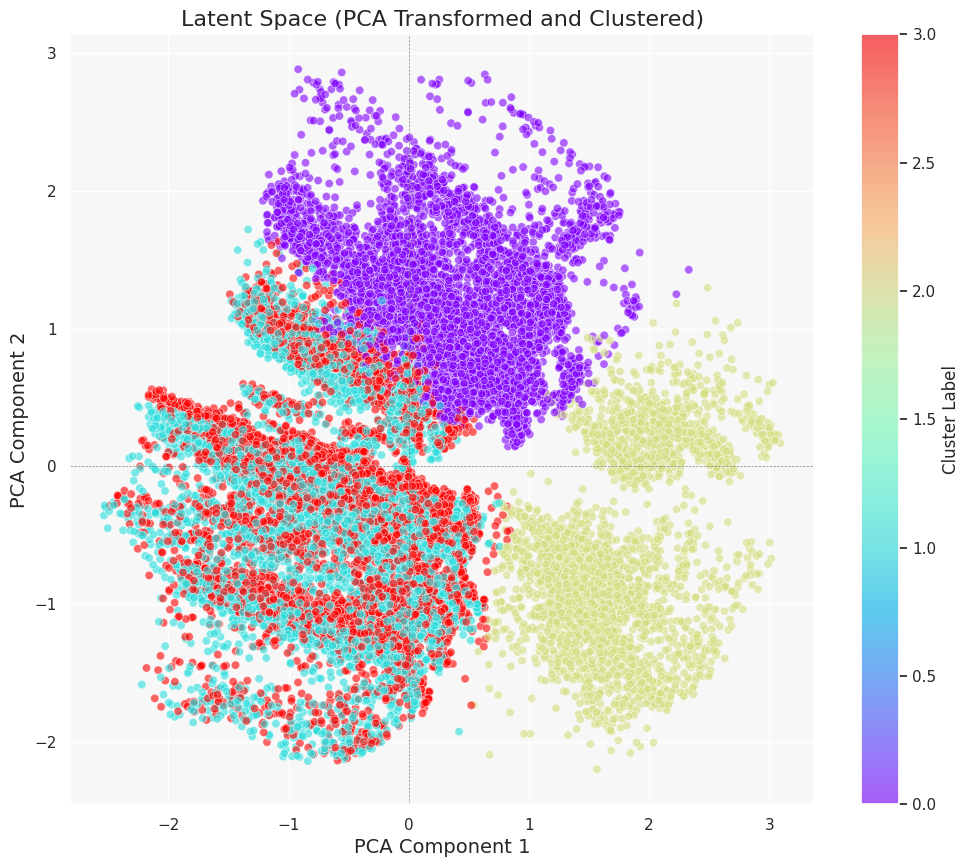

In [36]:
from sklearn.decomposition import PCA

# Assuming latent_representations are already obtained from the VAE model

# Step 1: Apply PCA to the Latent Representations
pca = PCA(n_components=2)
latent_representations_pca = pca.fit_transform(latent_representations)

# Step 2: Use the Elbow Method to Determine the Optimal Number of Clusters
def find_elbow_point(inertias):
    # Calculate the first derivative
    first_derivative = np.diff(inertias)
    # Calculate the second derivative
    second_derivative = np.diff(first_derivative)
    # Find the index of the highest curvature (elbow point)
    elbow_point = np.argmax(second_derivative) + 1
    return elbow_point

inertias = []
k_values = range(1, 15)  # Test for a range of cluster numbers

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(latent_representations)
    inertias.append(kmeans.inertia_)

elbow_index = find_elbow_point(inertias)
optimal_k = k_values[elbow_index]  # Get the corresponding number of clusters

# Step 3: Apply KMeans Clustering to the Latent Representations with the Optimal Number of Clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(latent_representations)

# Step 4: Scatter Plot of the PCA-transformed Latent Variables with Cluster Coloring
plt.figure(figsize=(12, 10))
scatter = plt.scatter(latent_representations_pca[:, 0], latent_representations_pca[:, 1], c=cluster_labels, cmap='rainbow', alpha=0.6, edgecolors='w', linewidths=0.5)
plt.title('Latent Space (PCA Transformed and Clustered)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('PCA Component 2', fontsize=14)
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.axhline(0, color='gray', lw=0.5, linestyle='--')
plt.axvline(0, color='gray', lw=0.5, linestyle='--')
plt.gca().set_facecolor('#f7f7f7')
plt.show()

# Cluster Analysis

In [37]:
from sklearn.metrics import silhouette_score

# Add the cluster labels to the DataFrame
gkone_data['Cluster'] = cluster_labels

# Calculate Silhouette Score
sil_score = silhouette_score(latent_representations, cluster_labels)
print(f'Silhouette Score: {sil_score}')

# Perform Cluster Analysis
# Calculate summary statistics for each cluster
cluster_summary = gkone_data.groupby('Cluster').mean()

# Set the option to display all columns
pd.set_option('display.max_columns', None)

# Display the summary statistics
print(cluster_summary)


Silhouette Score: 0.2094077616930008
         LinkedBankAccountMonthlyValue  PeerToPeer_MonthlyTransValue  \
Cluster                                                                
0                             0.350515                      1.300691   
1                            -0.056178                     -0.511248   
2                            -0.389221                      0.112350   
3                            -0.046970                     -0.512450   

         Remittances_MonthlyTransValue  BillPayments_MonthlyTransValue  \
Cluster                                                                  
0                             0.074304                       -0.329105   
1                             0.032604                       -0.329780   
2                            -0.290748                        2.202441   
3                             0.031273                       -0.329752   

         RemittancesFreq_Monthly  BillPaymentsFreq_Monthly  \
Cluster                

# **Cluster 0:**

This cluster shows a high value for Peer-to-Peer monthly transactions, suggesting frequent use of this service.
Moderate values for LinkedBankAccountMonthlyValue and BillPaymentsFreq_Monthly indicate balanced usage of banking and bill payment services.
The largest representation in the age groups is 25th-50th percentile, suggesting a younger demographic.
A balanced gender distribution with slight male predominance and significant usage of motor insurance and remittances.
Income levels show a mix of medium and high, indicating a moderately affluent group.
High educational attainment is distributed among college and high school graduates.
This cluster exhibits a higher likelihood of being located in low usage areas.

# **Cluster 1:**

This cluster contains Notably low values in LinkedBankAccountMonthlyValue and PeerToPeer_MonthlyTransValue indicate less engagement with these services.
The age distribution is skewed towards the lower age percentiles, with no females represented in this cluster.
Predominantly low-income individuals with higher unemployment and student statuses.
Moderate engagement with financial products, including PeerToPeer_Sending and remittances.
This cluster has a high percentage of customers located in low usage areas, making them potential targets for cross-selling lower-cost financial products to increase engagement.

# **Cluster 2:**

This Cluster contains High values for Remittances_MonthlyTransValue and BillPayments_MonthlyTransValue indicate heavy usage of remittance and bill payment services.
This group is predominantly older, with a significant representation in the 75th-100th percentile age group.
Balanced gender distribution with moderate engagement in motor insurance and marketplace transactions.
Moderate income levels with a significant portion in the low-income category.
This cluster is more likely to be found in moderate usage locations, suggesting that cross-selling could focus on products that cater to older demographics with lower income but higher financial service usage.

# **Cluster 3:**

Similar to Cluster 1, this group shows lower values for LinkedBankAccountMonthlyValue and PeerToPeer_MonthlyTransValue.
Balanced age distribution with a slight skew towards younger age groups.
All members are female, with moderate engagement in motor insurance and remittances.
Moderate educational attainment, predominantly among high school and college graduates.
Similar to Cluster 1, this group is mostly located in low usage areas, indicating potential for targeted marketing strategies to increase product usage.

# **Interesting Insights:**

Targeted Marketing: Each cluster exhibits unique characteristics, indicating the need for tailored marketing strategies. For instance, Clusters 0 and 2 could benefit from premium financial products, while Clusters 1 and 3 might require more affordable, accessible options.
Cross-Selling Opportunities: The high usage of specific financial products like remittances and bill payments in Clusters 0 and 2 provides a strong basis for cross-selling related services, such as remittances packages and incentives and bill payment incentives.
Demographic Focus: Clusters with specific age and income distributions can be targeted with age-appropriate financial products. For example, younger clusters (0 and 1) might be interested in digital banking solutions, while older clusters (2) might prefer traditional banking services with high customer support.
Gender-Specific Strategies: With distinct gender distributions, especially in Clusters 1 and 3, gender-specific financial products or marketing approaches could enhance engagement and product adoption.

## Cosine Similarity

In [38]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# List of products to recommend
product_columns = ['PeerToPeer_Sending', 'MotorInsurance', 'Remittances', 'MarketPlace', 'BillPayments']

# Function to recommend products/services based on cosine similarity with confidence scores
def recommend_products_with_confidence(new_customer_vector, data, top_n=5):
    # Ensure new customer vector is a numpy array and has the correct shape
    new_customer_vector = np.array(new_customer_vector).reshape(1, -1)

    # Calculate cosine similarity between the new customer and all other customers
    similarity_scores = cosine_similarity(new_customer_vector[:, :-len(product_columns)], data.drop(columns=product_columns))

    # Find the most similar customers
    most_similar_customers = np.argsort(similarity_scores[0])[::-1]  # Sort in descending order
    similar_customer_indices = most_similar_customers[:top_n]

    # Exclude products that the new customer is already using
    new_customer_products = new_customer_vector[0][-len(product_columns):]
    new_customer_products_used = [product_columns[i] for i in range(len(product_columns)) if new_customer_products[i] == 1]

    # Get product usage and similarity scores of the most similar customers
    similar_customers_products = data.iloc[similar_customer_indices][product_columns]
    similar_customers_scores = similarity_scores[0][similar_customer_indices]

    # Calculate the weighted mean usage of each product among the top N most similar customers
    weighted_usage = similar_customers_products.T.dot(similar_customers_scores)
    weighted_usage /= similar_customers_scores.sum()

    # Convert to percentages
    confidence_scores = (weighted_usage / weighted_usage.sum()) * 100

    # Exclude products that the new customer is already using
    recommended_products = confidence_scores.drop(new_customer_products_used)

    # Sort recommendations by confidence scores
    recommended_products = recommended_products.sort_values(ascending=False)

    return recommended_products